# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt



In [2]:
import traceback
from tqdm.notebook import tnrange

In [3]:
from scipy.special import logit, expit
from PolicyGradientAgent import StochasticGradientAgent

In [4]:
class PredictionMarket:
    n_outcomes = 0
    outcomes_list = []
    
    def __init__(self, outcomes_list):
        self.outcomes_list = outcomes_list.copy()
        self.n_outcomes = len(outcomes_list)
        self.init_prediction = np.ones(self.n_outcomes)/ self.n_outcomes
        self.current_prediction = self.init_prediction
        
    def report(self, prediction):
        assert len(prediction) == self.n_outcomes, 'Number of outcomes not fit!'
        assert sum(prediction) == 1, print('Probabilities not sum to one!', prediction)
        # Record the contract if multiple traders.
        self.current_prediction = prediction.copy()
        
    def log_resolve(self, materialised_index):
        assert materialised_index < self.n_outcomes, 'Index out of scope!'
        scores = np.log(self.current_prediction) - np.log(self.init_prediction)
        return scores[materialised_index]

In [5]:
class Bucket:
    
    def __init__(self, prior_red = 0.5):
        assert prior_red >= 0, 'Prior can not be negative!'
        assert prior_red <=1, 'Prior can not greater than one!'
        
        self.prior_red = prior_red
        self.colour = np.random.choice(['red_bucket', 'blue_bucket'], p=(self.prior_red, 1 - self.prior_red))
        if self.colour == 'red_bucket':
            self.ball_list = ['red', 'red', 'blue']
        else:
            self.ball_list = ['blue', 'blue', 'red']
    
    def signal(self):
        return np.random.choice(self.ball_list)

In [6]:
def one_hot_encode(feature):
    if feature == 'red':
        return [1, 0]
    else:
        return [0, 1]
    
bucket_colour_to_num = {'red_bucket': 0, 'blue_bucket': 1}

In [7]:
learning_rate_theta = 0.002
learning_rate_wv = 0.003
decay_rate = 0.0003
experience_size = 512
batch_size = 16
training_episodes = 6000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'adam'


agent = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta, learning_rate_wv=learning_rate_wv, experience_size= experience_size, batch_size=batch_size ,beta1=beta1, beta2=beta2)

q_ideal_reward_list = []

reward_history_list = []
average_reward = 0

mean_weights_history_list = []
std_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []
r_ball_std_history_list = []
b_ball_std_history_list = []

r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []
grad_r_ball_std_history_list = []
grad_b_ball_std_history_list = []

grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []
grad_r_ball_v_std_history_list = []
grad_b_ball_v_std_history_list = []

grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []
grad_r_ball_adam_std_history_list = []
grad_b_ball_adam_std_history_list = []

for t in tnrange(training_episodes):
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)
    h, mean, std = agent.report(x)
    pi = expit(h)
    report = [pi, 1 - pi]

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    reward_history_list.append([R, average_reward])
    mean_weights_history_list.append(agent.theta_mean[0].tolist())
    std_weights_history_list.append(agent.theta_std[0].tolist())    

    R_perf = 0
    red_score = np.log(report[0]) - np.log(0.5)
    blue_score = np.log(report[1]) - np.log(0.5)
    red_expectation = 2/3  * red_score + 1/3  * blue_score
    blue_expectation = 1/3  * red_score + 2/3  * blue_score
    if signal == 'red':
        R_perf = red_expectation
    else:
        R_perf = blue_expectation


    v = agent.store_experience(x, h, mean, std, R, t)

    q_ideal_reward_list.append([R_perf, v])

    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)

    if signal == 'red':
        r_ball_pred_history_list.append(report[0])
        r_ball_mean_history_list.append(mean)
        r_ball_std_history_list.append(std)
        grad_r_ball_mean_history_list.append(grad_mean[0])
        grad_r_ball_std_history_list.append(grad_std[0])
        ##########
        grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0])
        grad_r_ball_v_std_history_list.append(v_dw_std_corrected[0])
        grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0])
        grad_r_ball_adam_std_history_list.append(s_dw_std_corrected[0])
       
    else:
        b_ball_pred_history_list.append(report[0])
        b_ball_mean_history_list.append(mean)
        b_ball_std_history_list.append(std)
        grad_b_ball_mean_history_list.append(grad_mean[0])
        grad_b_ball_std_history_list.append(grad_std[0])
        #########
        grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0])
        grad_b_ball_v_std_history_list.append(v_dw_std_corrected[0])
        grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0])
        grad_b_ball_adam_std_history_list.append(s_dw_std_corrected[0])

  0%|          | 0/6000 [00:00<?, ?it/s]

0.0
Updating weights with adam algorithm.


In [8]:
q_ideal_reward_array = np.array(q_ideal_reward_list)

reward_history = np.array(reward_history_list)

mean_weights_history = np.array(mean_weights_history_list)
std_weights_history = np.array(std_weights_history_list)

grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)
grad_r_ball_std_history = np.array(grad_r_ball_std_history_list)
grad_b_ball_std_history = np.array(grad_b_ball_std_history_list)

grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)
grad_r_ball_v_std_history = np.array(grad_r_ball_v_std_history_list)
grad_b_ball_v_std_history = np.array(grad_b_ball_v_std_history_list)

grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)
grad_r_ball_adam_std_history = np.array(grad_r_ball_adam_std_history_list)
grad_b_ball_adam_std_history = np.array(grad_b_ball_adam_std_history_list)

In [31]:
std

0.317490130623684

Towards best ratio:  0.49677522117693906


Text(0.5, 0.98, 'Actual Rewards and Average')

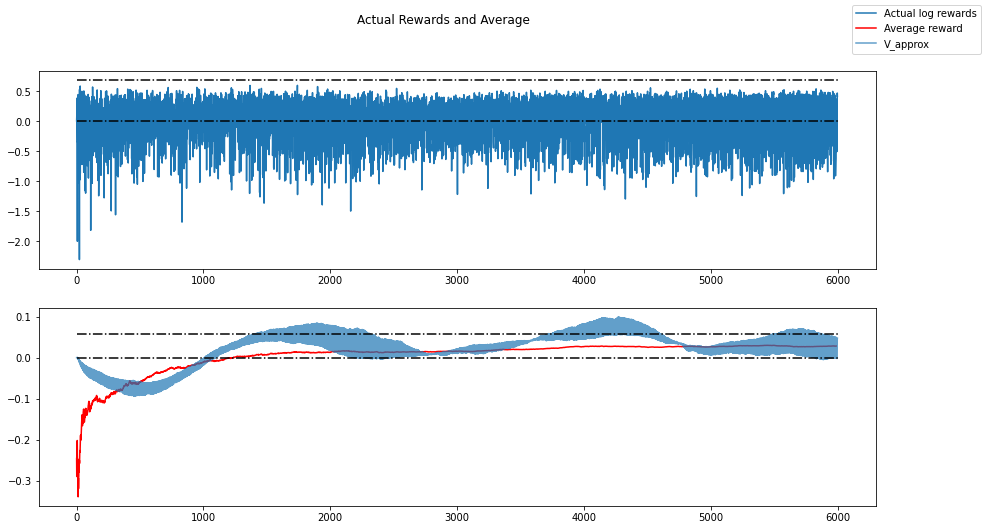

In [32]:
theoretical_best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
empirical_best = np.mean(reward_history[-100:, 1])
print('Towards best ratio: ', empirical_best/ theoretical_best)
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(reward_history[:, 0], label = 'Actual log rewards', zorder=-100)
axs[1].plot(reward_history[10:, 1], 'r',zorder= -99, label = 'Average reward')
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].plot(q_ideal_reward_array[:, 1], zorder= -98, label = 'V_approx', alpha = 0.7)
axs[1].hlines(y=theoretical_best, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

In [33]:
# fig = plt.figure(figsize=(15, 4))
# plt.plot(reward_history[:, 0], zorder = -100, label = 'Reward', alpha = 0.7)
# plt.plot(reward_history[:, 1], zorder= -99, label = 'Average reward')
# # plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
# plt.hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
# plt.hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
# plt.legend()
# plt.title('Rewards and Baseline')

Text(0.5, 1.0, 'Approximated value and Actual value')

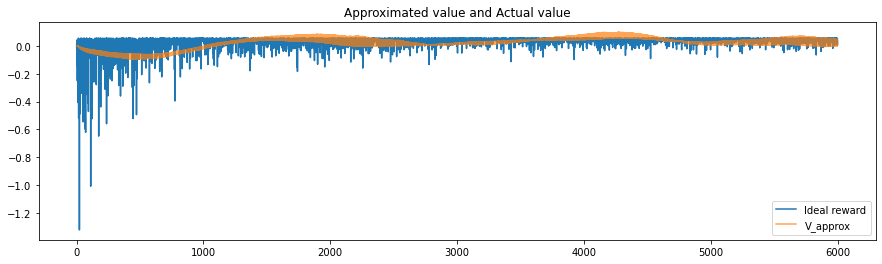

In [34]:
fig = plt.figure(figsize=(15, 4))
plt.plot(q_ideal_reward_array[:, 0], zorder = -100, label = 'Ideal reward')
plt.plot(q_ideal_reward_array[:, 1], zorder= -99, label = 'V_approx', alpha = 0.7)
# plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
# plt.hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
# plt.hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Approximated value and Actual value')

2956


Text(0.5, 1.0, 'Report')

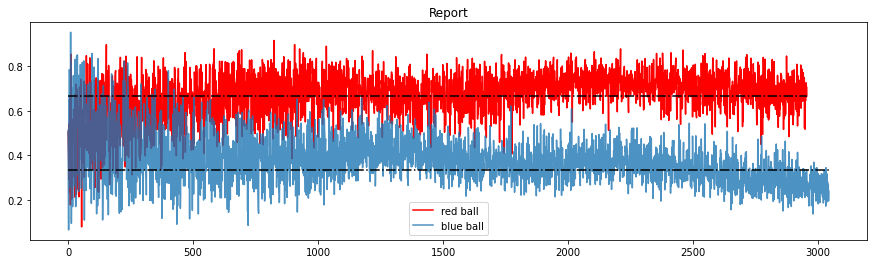

In [35]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history_list) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [36]:
print(agent.report([1, 0, 0.5]))

(1.2968717388645303, 0.7084645283690423, 0.3491175649452082)


In [37]:
print(agent.report([0, 1, 0.5]))

(-0.9990153981191897, -1.1032419118947685, 0.3175095664155585)


Text(0.5, 1.0, 'Mean')

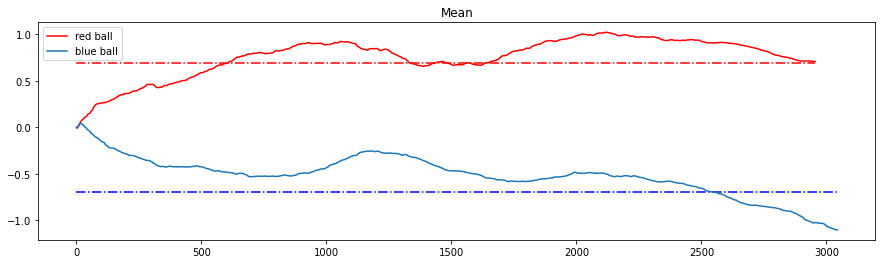

In [38]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history_list, 'r', label = 'red ball')
plt.plot(b_ball_mean_history_list,label = 'blue ball')
plt.hlines(y=np.log(2), xmin=0, xmax=len(r_ball_mean_history_list), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(b_ball_mean_history_list) , colors='blue', linestyles='dashdot')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

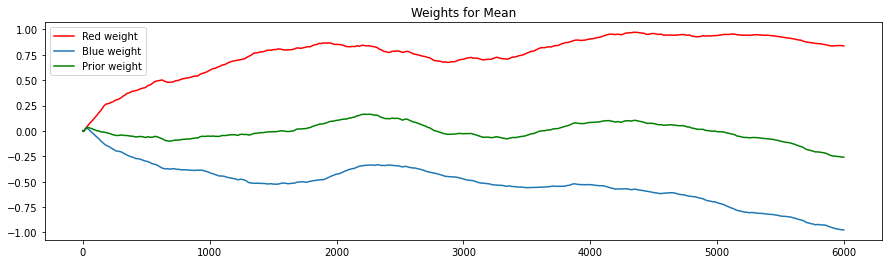

In [39]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 1.0, 'Standard Diviation')

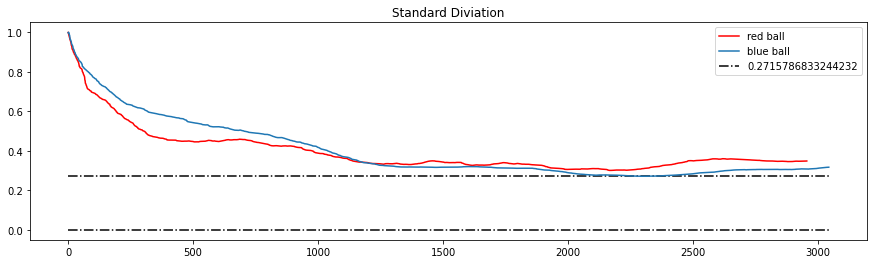

In [40]:
min_std = min(r_ball_std_history_list) if min(r_ball_std_history_list) < min(b_ball_std_history_list) else min(b_ball_std_history_list)
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_std_history_list, 'r', label = 'red ball')
plt.plot(b_ball_std_history_list,label = 'blue ball')
plt.hlines(y=0, xmin=0, xmax=len(b_ball_std_history_list) , colors='black', linestyles='dashdot')
plt.hlines(y=min_std, xmin=0, xmax=len(b_ball_std_history_list) , colors='black', linestyles='dashdot', label=str(min_std))
plt.legend()
plt.title('Standard Diviation')

Text(0.5, 1.0, 'Weights for standard diviation')

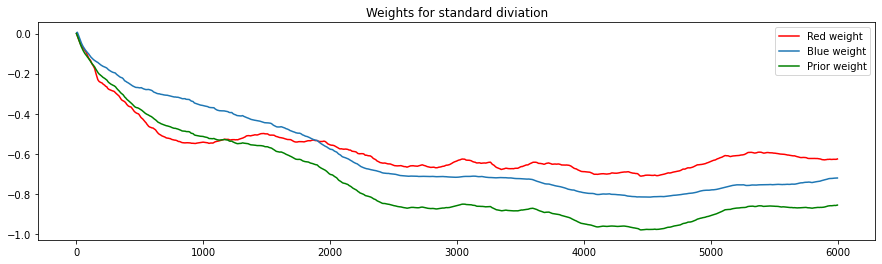

In [41]:
fig = plt.figure(figsize=(15, 4))
plt.plot(std_weights_history[:, 0], 'r', label='Red weight')
plt.plot(std_weights_history[:, 1], label='Blue weight')
plt.plot(std_weights_history[:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

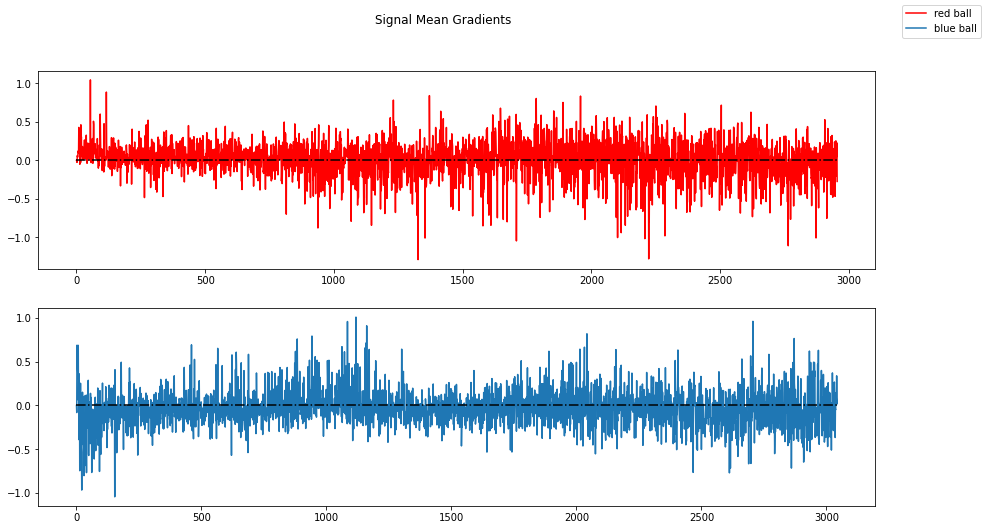

In [42]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

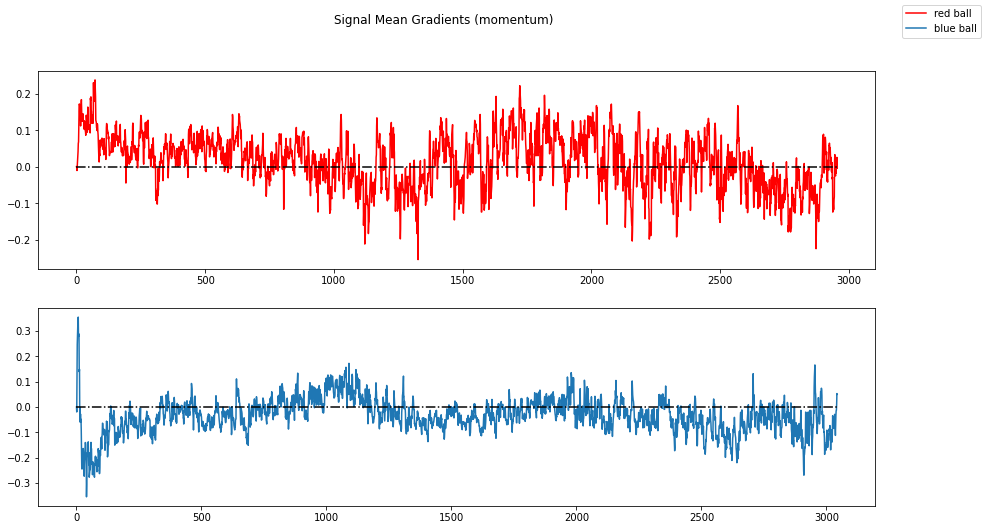

In [43]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

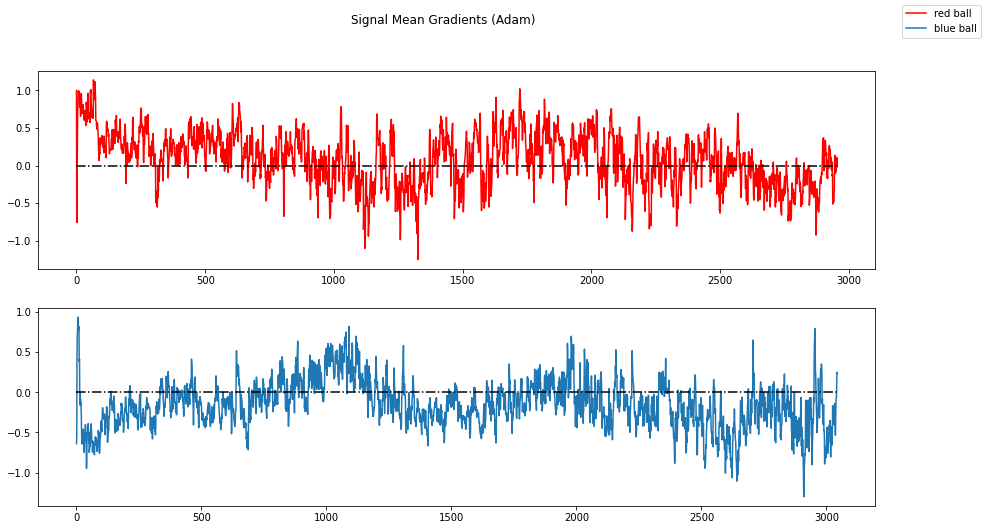

In [44]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

Text(0.5, 0.98, 'Prior Mean Gradient')

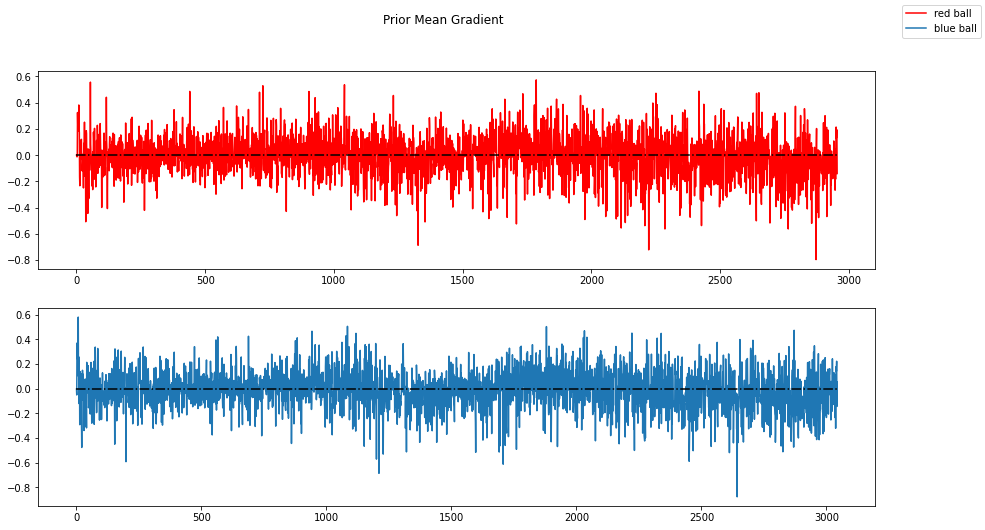

In [45]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Prior Mean Gradient (Momentum)')

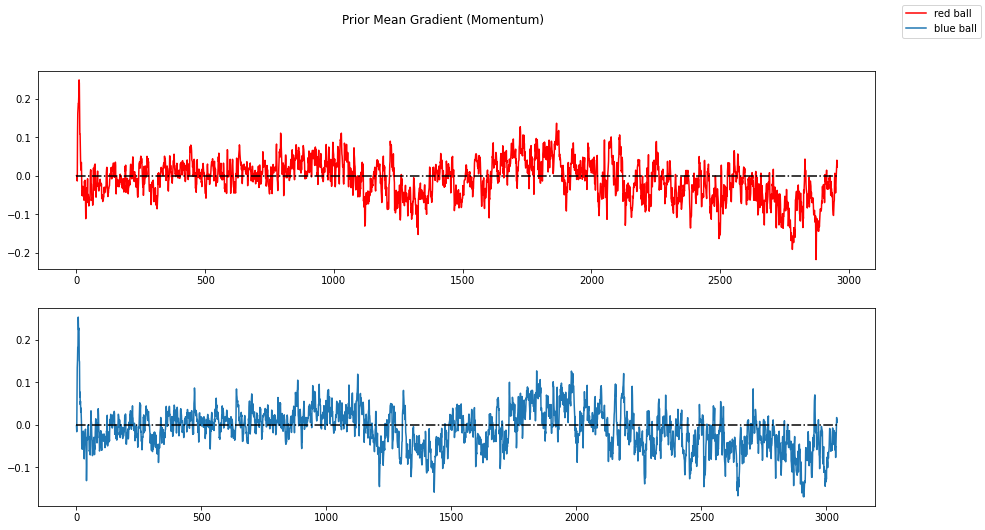

In [46]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

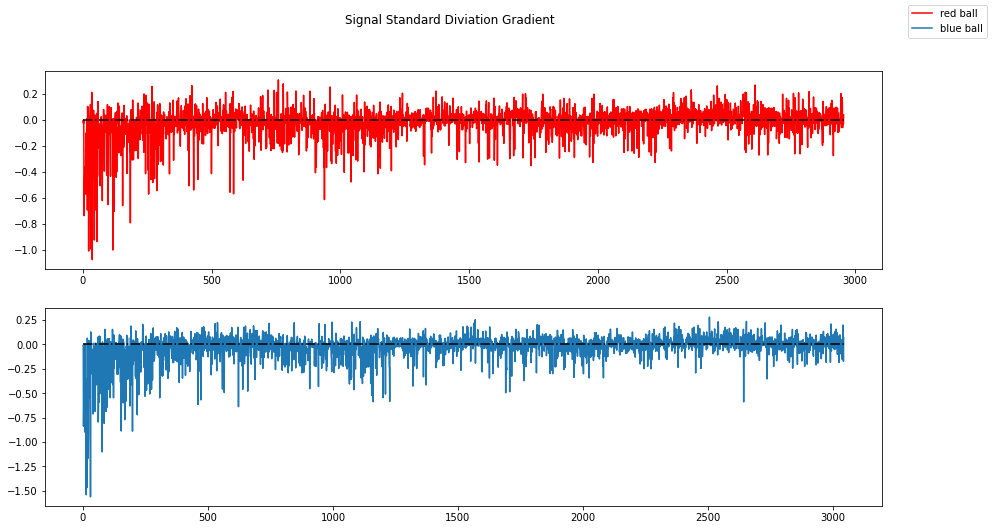

In [47]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_std_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_std_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Momentum)')

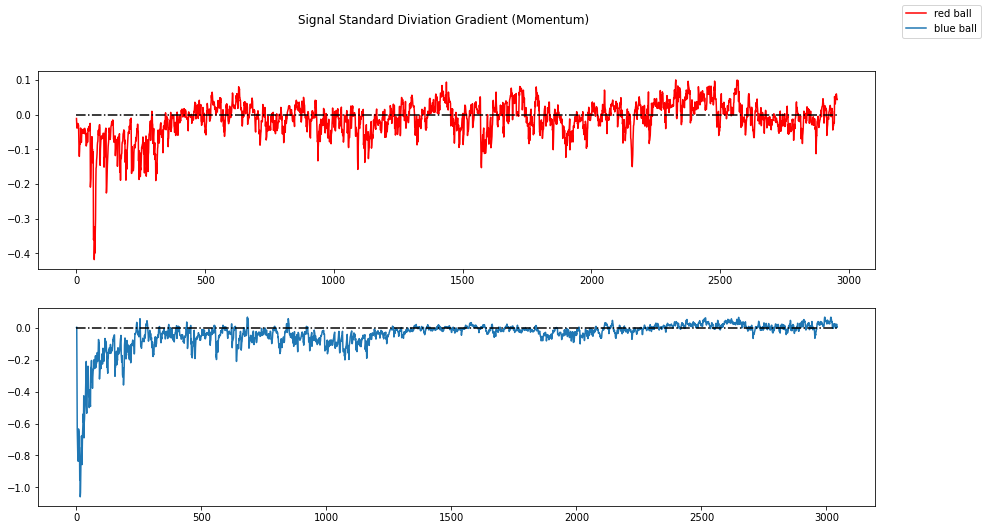

In [48]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_std_history[:, 0], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_std_history[:, 1],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Adam)')

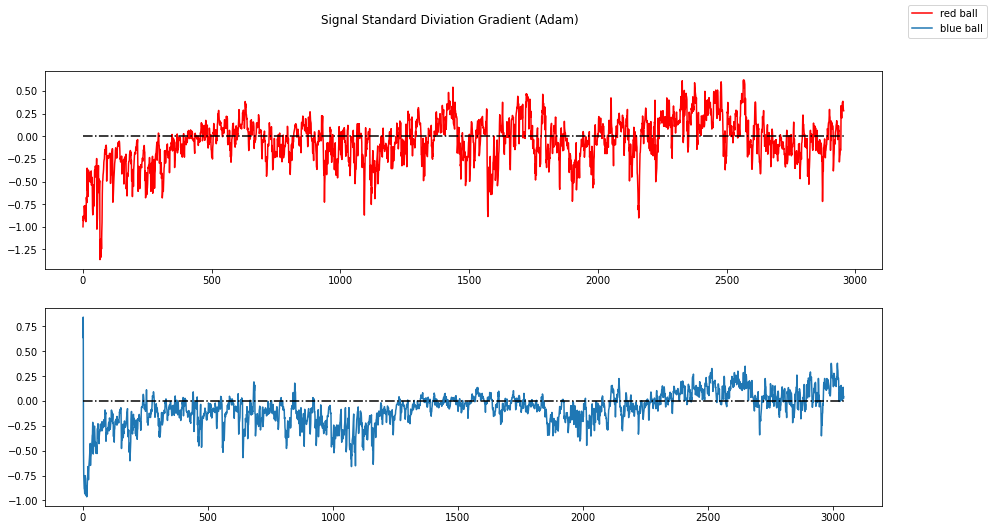

In [49]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_std_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_std_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Adam)')